In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

# Download and import visualkeras library
!pip install visualkeras
import visualkeras

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.8.0
     |████████████████████████████████| 992 kB 7.8 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd 'drive/MyDrive/Colab Notebooks/EESTEC_challenge'

/content/drive/MyDrive/Colab Notebooks/EESTEC_challenge


In [4]:
from os import listdir
from matplotlib import image
# load all images in a directory
anomaly = list()
for filename in listdir('training/anomaly'):
	# load image
	img_data = image.imread('training/anomaly/' + filename)
	# store loaded image
	anomaly.append(img_data)
	# print('> loaded %s %s' % (filename, img_data.shape))

anomaly = np.array(anomaly)
print(anomaly.shape)

no_anomaly = list()
for filename in listdir('training/no_anomaly'):
	# load image
	img_data = image.imread('training/no_anomaly/' + filename)
	# store loaded image
	no_anomaly.append(img_data)
	# print('> loaded %s %s' % (filename, img_data.shape))

no_anomaly = np.array(no_anomaly)
print(no_anomaly.shape)

test = list()
for filename in listdir('test'):
	# load image
	img_data = image.imread('test/' + filename)
	# store loaded image
	test.append(img_data)
	# print('> loaded %s %s' % (filename, img_data.shape))

test = np.array(test)
print(test.shape)

(452, 224, 224, 3)
(1216, 224, 224, 3)
(417, 224, 224, 3)


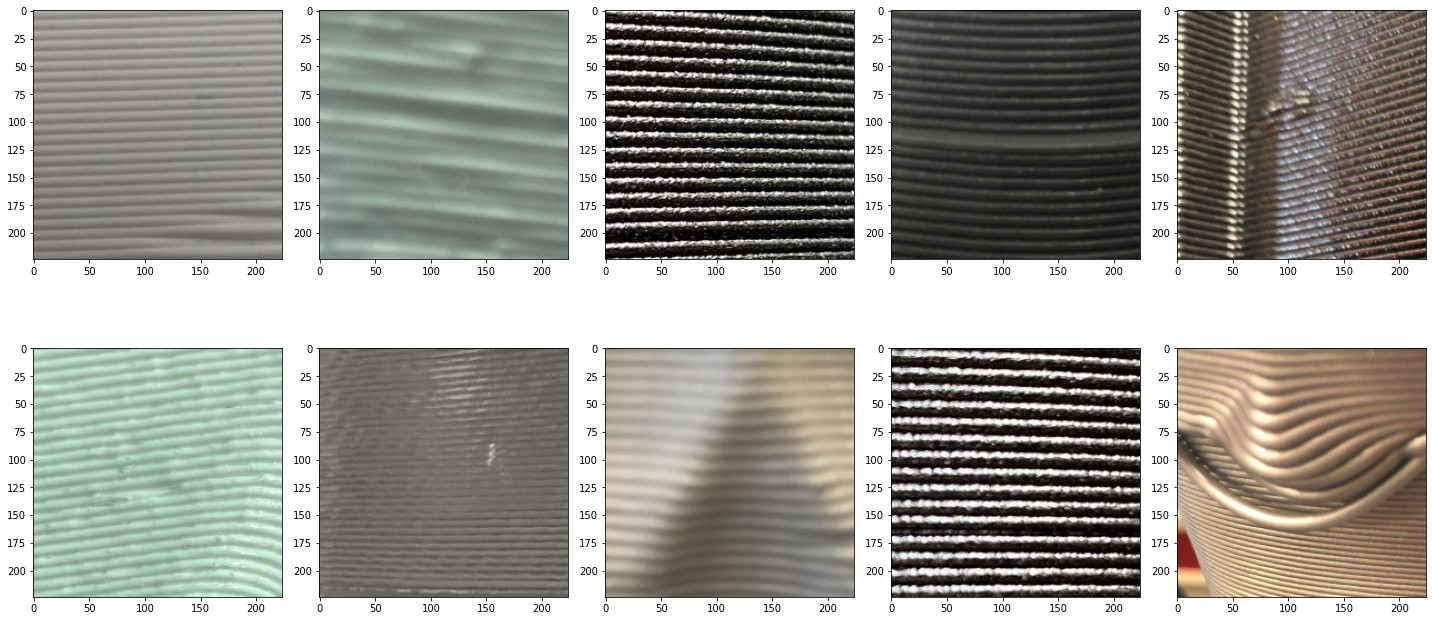

In [ ]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col] # i//num_col è la divisione senza resto (quindi l'output dell'operazione è un intero)
                                     # i%num_col è il resto della divisione tra i e num_col
    ax.imshow(anomaly[i])
plt.tight_layout() # to correctly space the plots
plt.show()

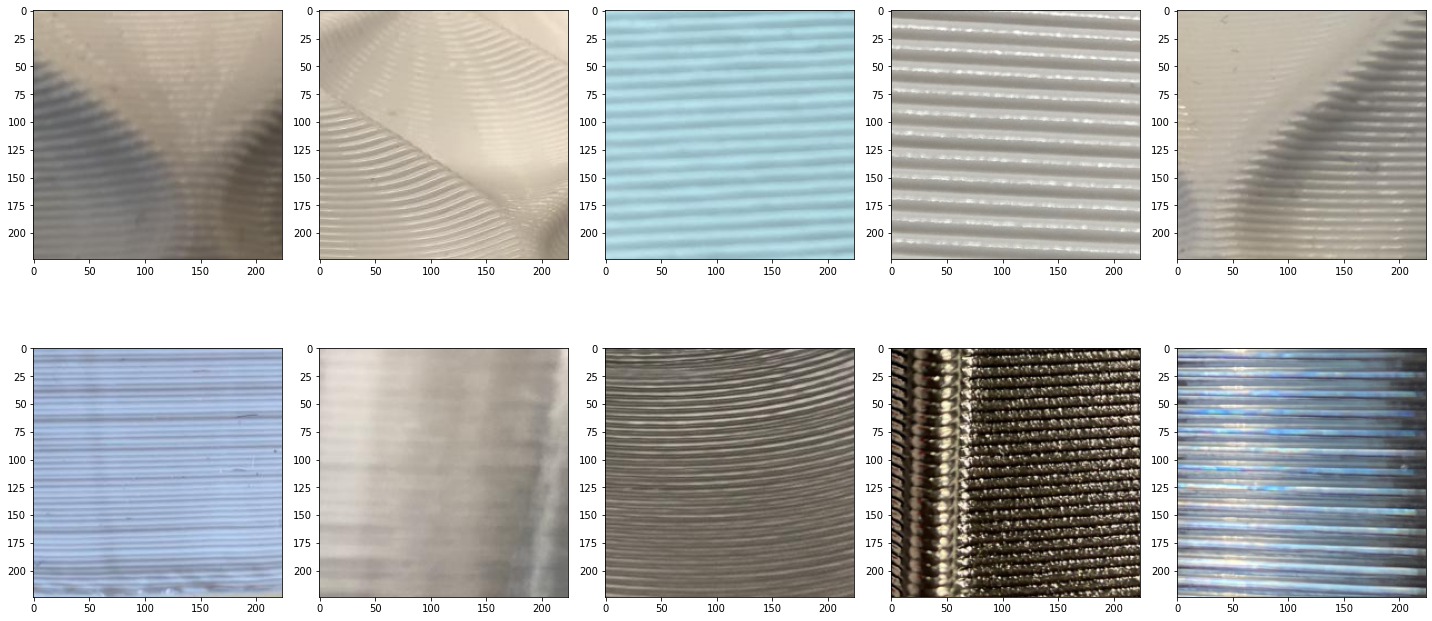

In [ ]:
# Inspect the data
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col] # i//num_col è la divisione senza resto (quindi l'output dell'operazione è un intero)
                                     # i%num_col è il resto della divisione tra i e num_col
    ax.imshow(no_anomaly[i])
plt.tight_layout() # to correctly space the plots
plt.show()

In [ ]:
# # Normalize data
Xtrain = np.concatenate((anomaly, no_anomaly), axis = 0)
# Xtrain = Xtrain/255. # each datum is an intesity level
# test = test/255.

# Apply same preprocessing used to train the supernet 
Xtrain = tfk.applications.inception_v3.preprocess_input(Xtrain)
test = tfk.applications.inception_v3.preprocess_input(test)

In [ ]:
# get the labels
y_train = np.concatenate((np.ones((anomaly.shape[0],1)), np.zeros((no_anomaly.shape[0],1))), axis = 0)

In [ ]:
# reshaffle data
from sklearn.utils import shuffle

Xtrain, y_train = shuffle(Xtrain, y_train)

In [ ]:
# Split in train and test
Xtrain, Xval, y_train, y_val = train_test_split(Xtrain, y_train, random_state=seed, test_size=.2, stratify=y_train)
Xtrain.shape, y_train.shape, Xval.shape, y_val.shape

((1334, 224, 224, 3), (1334, 1), (334, 224, 224, 3), (334, 1))

In [ ]:
y_train_cat = tfk.utils.to_categorical(y_train)
y_val_cat = tfk.utils.to_categorical(y_val)

In [ ]:
input_shape = Xtrain.shape[1:] # X_train.shape[:] = (num. of samples in training set, height, width, channels). We only care about the last two numbers.
batch_size = 64
epochs = 200
print(input_shape)

(224, 224, 3)


In [ ]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(224,224,3)
)

In [ ]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(224,224,3))
# x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    128, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    64, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    2, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 25088)             0         
                                                                 
 dropout (Dropout)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896 

In [ ]:
# def build_model(input_shape):

#     # Build the neural network layer by layer
#     input_layer = tfkl.Input(shape=input_shape, name='Input')

#     conv1 = tfkl.Conv2D(
#         filters=16,
#         kernel_size=(3, 3),
#         strides = (1, 1),
#         padding = 'same',
#         activation = 'relu',
#         kernel_initializer = tfk.initializers.GlorotUniform(seed)
#     )(input_layer)
#     pool1 = tfkl.MaxPooling2D(
#         pool_size = (2, 2)
#     )(conv1)

#     conv2 = tfkl.Conv2D(
#         filters=32,
#         kernel_size=(3, 3),
#         strides = (1, 1),
#         padding = 'same',
#         activation = 'relu',
#         kernel_initializer = tfk.initializers.GlorotUniform(seed)
#     )(pool1)
#     pool2 = tfkl.MaxPooling2D(
#         pool_size = (2, 2)
#     )(conv2)

#     conv3 = tfkl.Conv2D(
#         filters=64,
#         kernel_size=(3, 3),
#         strides = (1, 1),
#         padding = 'same',
#         activation = 'relu',
#         kernel_initializer = tfk.initializers.GlorotUniform(seed)
#     )(pool2)
#     pool3 = tfkl.MaxPooling2D(
#         pool_size = (2, 2)
#     )(conv3)

#     flattening_layer = tfkl.Flatten(name='Flatten')(pool3)
#     flattening_layer = tfkl.Dropout(0.3, seed=seed)(flattening_layer)
#     classifier_layer = tfkl.Dense(units=128, name='Classifier', activation='relu')(flattening_layer)
#     classifier_layer = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
#     output_layer = tfkl.Dense(units=2, activation='softmax', name='Output')(classifier_layer)

#     # Connect input and output through the Model class
#     model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

#     # Compile the model
#     model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

#     # Return the model
#     return model

In [ ]:
# model = build_model(input_shape)
# model.summary()
# visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [ ]:
print(y_val_cat.shape, y_train_cat.shape)

(334, 2) (1334, 2)


In [ ]:
# Train the model
history = tl_model.fit(
    x = Xtrain,
    y = y_train_cat,
    batch_size = batch_size,
    epochs = epochs,
    validation_data=(Xval, y_val_cat),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
21/21 [==============================] - 26s 968ms/step - loss: 3.3637 - accuracy: 0.6379 - val_loss: 1.2243 - val_accuracy: 0.7246
Epoch 2/200
21/21 [==============================] - 14s 676ms/step - loss: 2.2891 - accuracy: 0.6762 - val_loss: 0.6643 - val_accuracy: 0.7186
Epoch 3/200
21/21 [==============================] - 14s 681ms/step - loss: 1.5854 - accuracy: 0.6934 - val_loss: 0.6157 - val_accuracy: 0.7485
Epoch 4/200
21/21 [==============================] - 14s 685ms/step - loss: 0.9651 - accuracy: 0.7151 - val_loss: 0.5619 - val_accuracy: 0.7874
Epoch 5/200
21/21 [==============================] - 14s 686ms/step - loss: 0.8089 - accuracy: 0.7519 - val_loss: 0.5440 - val_accuracy: 0.7934
Epoch 6/200
21/21 [==============================] - 14s 686ms/step - loss: 0.5876 - accuracy: 0.7819 - val_loss: 0.5094 - val_accuracy: 0.8054
Epoch 7/200
21/21 [==============================] - 14s 686ms/step - loss: 0.5573 - accuracy: 0.8051 - val_loss: 0.4379 - val_accuracy:

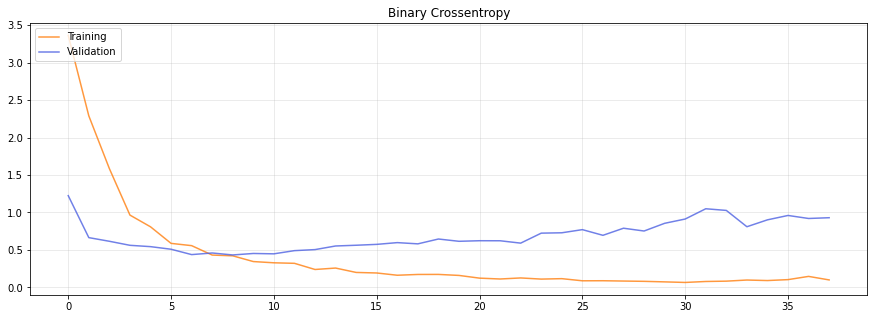

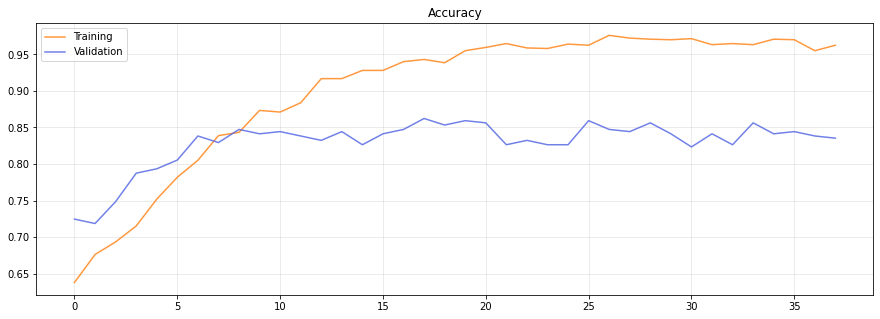

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Accuracy: 0.8623
Precision: 0.8402
Recall: 0.7988
F1: 0.8156


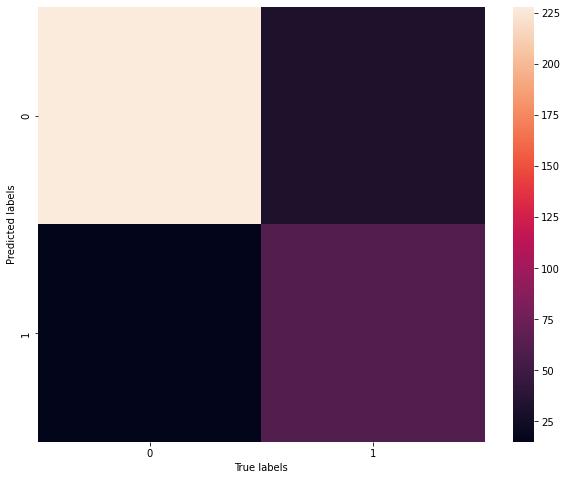

In [ ]:
# Predict the test set with the CNN
predictions = tl_model.predict(Xval)
predictions.shape

# Compute the confusion matrix
cm = confusion_matrix(np.argmax(y_val_cat, axis=-1), np.argmax(predictions, axis=-1))

# Compute the classification metrics
accuracy = accuracy_score(np.argmax(y_val_cat, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val_cat, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val_cat, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val_cat, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [ ]:
tl_model.save('transfer_learning')


INFO:tensorflow:Assets written to: transfer_learning/assets
